# Modeling - Recurrent Neural Network (LSTM) - BTC

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [13]:
df = pd.read_csv('../data/ohlc_price.csv')
df.tail()

,t,c,h,l,o
3767,2020-11-08,15486.128766,15637.320338,14768.714354,14837.102140
3768,2020-11-09,15336.738598,15784.249226,14865.529277,15473.556776
3769,2020-11-10,15289.794466,15449.620803,15125.106318,15336.435511
3770,2020-11-11,15693.906873,15908.693496,15290.006817,15305.071062
3771,2020-11-12,16281.414512,16304.983801,15534.843122,15687.777568


## Preprocessing Data

In [14]:
df.rename(columns={'t':'Date','c':'Close','h':'High','l':'Low','o':'Open'}, inplace=True)

In [15]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [16]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2018-02-17,0.602915
2018-02-18,0.563933
2018-02-19,0.612751
2018-02-20,0.626067
2018-02-21,0.571384


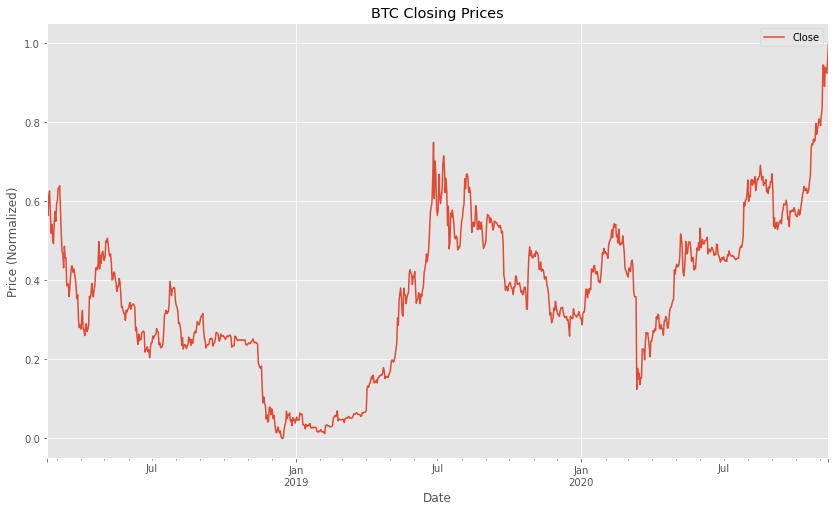

In [17]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Functions to prepare the data for LSTM

In [18]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [19]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [20]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [21]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [22]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_12 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 12)            1200      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 12)           

In [23]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [24]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
27/27 [==============================] - 2s 85ms/step - loss: 0.1035 - accuracy: 0.1956 - val_loss: 0.2803 - val_accuracy: 0.0825
Epoch 2/800
27/27 [==============================] - 2s 56ms/step - loss: 0.0561 - accuracy: 0.1389 - val_loss: 0.1707 - val_accuracy: 0.0619
Epoch 3/800
27/27 [==============================] - 1s 48ms/step - loss: 0.0349 - accuracy: 0.0718 - val_loss: 0.1187 - val_accuracy: 0.0619
Epoch 4/800
27/27 [==============================] - 1s 46ms/step - loss: 0.0284 - accuracy: 0.0868 - val_loss: 0.1142 - val_accuracy: 0.0722
Epoch 5/800
27/27 [==============================] - 1s 44ms/step - loss: 0.0185 - accuracy: 0.1343 - val_loss: 0.0524 - val_accuracy: 0.0619
Epoch 6/800
27/27 [==============================] - 1s 43ms/step - loss: 0.0134 - accuracy: 0.1030 - val_loss: 0.0609 - val_accuracy: 0.0722
Epoch 7/800
27/27 [==============================] - 1s 43ms/step - loss: 0.0121 - accuracy: 0.1285 - val_loss: 0.0633 - val_accuracy: 0.0619
Epoch 

### Plotting the Accuracy and Loss

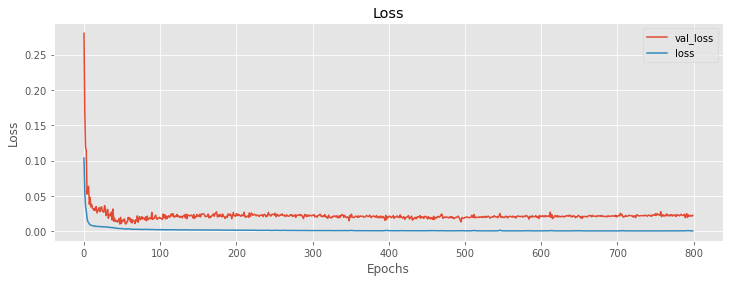

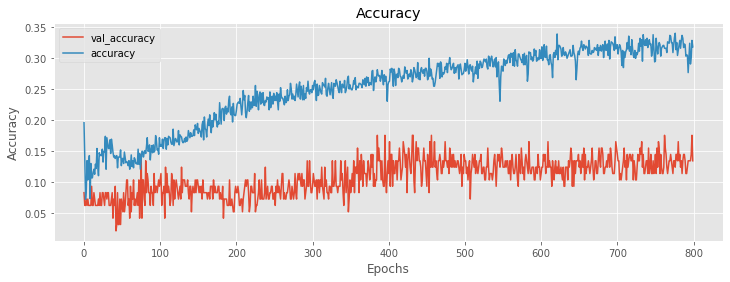

In [25]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

Predicted Prices:
 [[10847.304070519285], [11066.613928313336], [11277.695458198137], [11471.068550356293], [11677.316336065356], [11812.919304410496], [11907.900783579908], [11790.713781866018], [11709.413268197048], [11467.195801483951]]

Actual Prices:
 [[13914.806921199463], [14127.434501432557], [15556.660674219534], [15552.789426236755], [14849.092332069496], [15486.128766242586], [15336.738597655205], [15289.794466324058], [15693.906873452925], [16281.414511965559]]


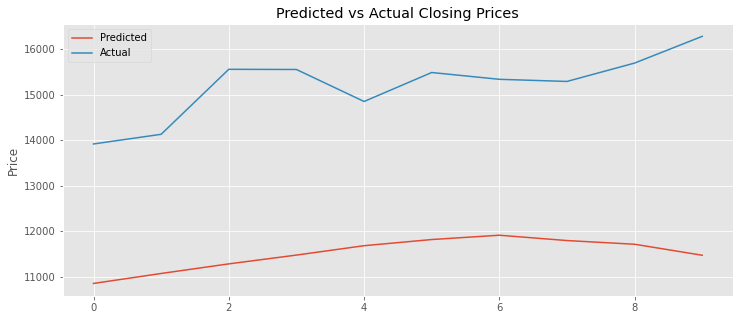

In [26]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

                   Close
2020-11-12  10219.051058
2020-11-13  10259.590910
2020-11-14   9915.047658
2020-11-15   9988.685090
2020-11-16  10109.302440
2020-11-17  10668.157752
2020-11-18  10897.590716
2020-11-19  11497.578337
2020-11-20  12284.662258
2020-11-21  12111.512830


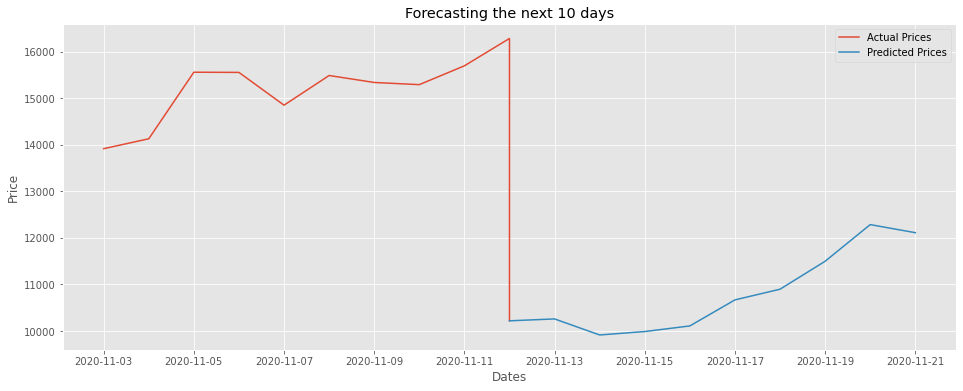

In [27]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()